# Why some methods are more resistant to overfitting?

According to statistical learning theory for all **reasonable machine learning methods** training and test errors converge to the true risk when the number of training samples grows. However, the convergence speeds really depends on many factors. The following notebook highlights the differences and causes behind them.    

In [556]:
import numpy as np
import numpy.random as random
import pandas as pd

from pandas import Series
from pandas import DataFrame
from pandas import melt
from typing import List

from numpy.random import choice
from numpy.random import uniform
from scipy.stats import binom

# Local imports
from convenience import mdisplay
from convenience import combine_categories

from plotnine import *
from plotnine import options

In [4]:
# Kill duplication
import sys
sys.path.append('../')
from common import data_sampler
from common import MajorityVoting

**Random functions** 

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logit(x:Series, w:Series):
    """
    Randomly labels output according to logit model pr[y=1|sigmoid(w*x)]
    
    You can omit trailing zeroes in w by specifying only first non-zero coefficients  
    """
    return random.rand() <= sigmoid(np.dot(x.iloc[0:len(w)] - 0.5, w))

**Data generation**

In [3]:
def data_sampler(n:int, k:int,  f:callable) -> DataFrame:
    """
    Data generator that generates n x k feature matrix and a target vector
    
    Returns a data frame with columns x_1, ..., x_k, y where y is computed
    using randomised labelling function f.
    """
    
    columns = ['x_{}'.format(num) for num in range(1, k + 1)]
    return (DataFrame(random.rand(n, k), columns = columns)
            .transform(lambda x: x >= 0.5)
            .assign(y = lambda df: df.apply(f, axis=1)))

## III. Numerical examples 

* The size of the dataset and nature of the labelling function determine the difficulty of the problem.
* If the target function is near-deterministic then there exists a good predictor.
* If the number of features is small then it is easier to learn the target function.
* **Clarification:** Target function is a perfect mathematical model of the actual process that maps features to labels.

###  Choosing among target functions

* Let's build a target function that outputs `True` if at least one input is `True`.
* The weights `w = [1, 1]` achieve this most of the time. Still the relation does not always hold.
* Larger weights `[10, 10]` increase certainty and smaller weights `[0.1, 0.1]` decrease certainty.
* **Clarification:** Certainty quantifies whether the result occurs always or the outcome is random.  

In [4]:
fs = lambda x: logit(x, Series([1, 1]))
X = data_sampler(1000, 2, fs)
X.head()

,x_1,x_2,y
0,False,True,False
1,True,True,True
2,False,False,False
3,True,True,True
4,True,False,True


Let see what is the fraction of `True` values for each input

In [5]:
S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
S.columns = S.columns.droplevel(0)  
S = S.assign(freq = lambda df: round(df['sum']/df['count'] * 100))
S.reset_index()

,x_1,x_2,count,sum,freq
0,False,False,252,62,25.0
1,False,True,264,133,50.0
2,True,False,237,120,51.0
3,True,True,247,182,74.0


The relation between inputs and output is not so clear:
* Let's experiment with different weights to see what happens.
* For simplicity, let's convert the previous analysis to a function.

In [6]:
def summarize(X:DataFrame) -> DataFrame:
    S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
    S.columns = S.columns.droplevel(0)  
    return (S.assign(freq = lambda df: round(df['sum']/df['count'] * 100)).
            reset_index())  
display(summarize(X))

,x_1,x_2,count,sum,freq
0,False,False,252,62,25.0
1,False,True,264,133,50.0
2,True,False,237,120,51.0
3,True,True,247,182,74.0


To estimate the effect of statistical fluctuations we do two experiments and compare results.

In [7]:
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 234 
 0 
 0.0 
 
 
 False 
 True 
 267 
 127 
 48.0 
 
 
 True 
 False 
 250 
 137 
 55.0 
 
 
 True 
 True 
 249 
 249 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 266 
 0 
 0.0 
 
 
 False 
 True 
 237 
 108 
 46.0 
 
 
 True 
 False 
 258 
 130 
 50.0 
 
 
 True 
 True 
 239 
 239 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 260 
 120 
 46.0 
 
 
 False 
 True 
 249 
 118 
 47.0 
 
 
 True 
 False 
 244 
 134 
 55.0 
 
 
 True 
 True 
 247 
 141 
 57.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 247 
 122 
 49.0 
 
 
 False 
 True 
 275 
 140 
 51.0 
 
 
 True 
 False 
 249 
 126 
 51.0 
 
 
 True 
 True 
 229 
 128 
 56.0

**Conclusion:** The number of samples is too small to get an accurate probability estimate.

In [8]:
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 24911 
 0 
 0.0 
 
 
 False 
 True 
 25122 
 12626 
 50.0 
 
 
 True 
 False 
 25162 
 12569 
 50.0 
 
 
 True 
 True 
 24805 
 24804 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25082 
 0 
 0.0 
 
 
 False 
 True 
 24933 
 12241 
 49.0 
 
 
 True 
 False 
 24952 
 12553 
 50.0 
 
 
 True 
 True 
 25033 
 25033 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25183 
 12049 
 48.0 
 
 
 False 
 True 
 24839 
 12412 
 50.0 
 
 
 True 
 False 
 25125 
 12522 
 50.0 
 
 
 True 
 True 
 24853 
 13012 
 52.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25076 
 11928 
 48.0 
 
 
 False 
 True 
 24924 
 12562 
 50.0 
 
 
 True 
 False 
 24885 
 12531 
 50.0 
 
 
 True 
 True 
 25115 
 13197 
 53.0

* Weight vector `w = [10, 10]` creates predictable instances.
* Weight vector `w = [0.1, 0.1]` creates almost unpredictable instances.

### Choosing learning tasks to compare

* Let's experiment with predictable and almost unpredictable labelling functions.
* Let's experiment with small and big number of features.

In [9]:
sampler_11 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([10, 10])))
sampler_10 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([0.1, 0.1])))
sampler_01 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([10, 10])))
sampler_00 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([0.1, 0.1])))

## III. Learning algorithms

* Let's observe the behaviour of several algorithms.
* Majority voting is the simplest and the best classification algorithm:
  * It is optimal if the number of samples is large enough to cover each possible input.
  * It is theoretically optimal – we cannot do better without extra knowledge about the data.
* Logistic regression can work with fewer samples:
  * It makes extra assumptions about the labelling function.
  * As a result, there are fewer parameters to learn.
  * The convergence to the final classification algorithm is faster.

### The best theoretical  fit  
* As the data is generated by logit function the target function is in the model class of logistic regression.
* That is there is a vector of coefficients for the logistic regression that represents the target function if we also consider the noise parameters.
* Majority voting cannot trully represent the target function as it always outputs a deterministic function and there is no noise estimation. 
* The best predictor for the target function is among the functions the majority voting algorithm can produce.
* The best predictor for the target function is among the functions the logistic regression algorithm can produce if we ignore noise parameters.
    

###  Majority voting algorithm

* Our implementation corresponds to `sklearn` prediction API:
  * constructor for fixing free hyperparameters
  * method `fit(samples, targets)` to train the model
  * method `predict(samples)` to predict labels
  * method `set_params(...)` to set hyperparameters  

In [43]:
class MajorityVoting:
    
    def __init__(self, features:List[str]=None):
        if features:
            self.features = list(features)
        else:
            self.features = None
    
    def set_params(features: List[str]) -> None:
        self.features = features
    
    def fit(self, X: DataFrame, y: Series) -> None:
        
        if self.features is None:
            self.features = list(X.columns.values)

        data = X.assign(y = y)
        pred = data.groupby(self.features).aggregate(['count', 'sum'])
        pred.columns = pred.columns.droplevel(0)
        self.pred = DataFrame({'prediction':(pred['sum']/pred['count'] >= 0.5)})
    
    def predict(self, X: DataFrame) -> np.array:
        
        return (X[self.features]
                .join(self.pred, on=self.features, how='left')['prediction']
                .astype(bool)
                .fillna(True)
                .values)

**Majority voting:** example run

In [11]:
clf = MajorityVoting()
data = sampler_11(2)
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
mdisplay([data, clf.pred],['Data', 'Predictor'])

Data Predictor 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 True 
 False 
 True 
 
 
 True 
 True 
 True 
 
 
 
 
 
 prediction 
 
 
 
 
 True 
 
 
 True

**Logistic regression:** example run

* The example below could fail if the generated 2-instances dataset has only one unique label. 
* To see output of this cell correctly, you can rerun this cell until no errors are thrown.

In [12]:
from sklearn.linear_model import LogisticRegression
data = sampler_11(2)

clf = LogisticRegression(solver = 'lbfgs')
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
clf.predict(data[features])

array([ True, False])

## IV.  Convergence plots for accuracy

* We generate different datasets of different sizes and estimate classifiers' performance on the test set.
* To eliminate fluctuations based on test data generation, we use the same testset for all training set sizes.

### Generation of training and test data

In [13]:
sizes = [10, 50, 100] + list(range(200, 1001, 100)) + list(range(2000, 5001, 1000))

train_00 = [sampler_00(n) for n in sizes]
features_00 = list(train_00[0].columns.values[0:-1])

train_01 = [sampler_01(n) for n in sizes]
features_01 = list(train_01[0].columns.values[0:-1])

train_10 = [sampler_10(n) for n in sizes]
features_10 = list(train_10[0].columns.values[0:-1])

train_11 = [sampler_11(n) for n in sizes]
features_11 = list(train_11[0].columns.values[0:-1])

n = 10000
test_00 = sampler_00(n)
test_01 = sampler_01(n)
test_10 = sampler_10(n)
test_11 = sampler_11(n)

### Majority Voting example  

To work out the details, it is always easier to do the analysis for one dataset.

In [14]:
test = test_11
train = train_11[1]
clf = MajorityVoting(features_11)
clf.fit(train, train['y'])
display(clf.pred)

prediction
x_1   x_2              
False False       False
      True        False
True  False        True
      True         True

In [15]:
mdisplay([train.head(), DataFrame(clf.predict(train)).head()], ['Data', 'Prediction'])

Data Prediction 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 True 
 False 
 True 
 
 
 True 
 False 
 False 
 
 
 True 
 False 
 True 
 
 
 True 
 True 
 True 
 
 
 False 
 False 
 False 
 
 
 
 
 
 0 
 
 
 
 
 True 
 
 
 True 
 
 
 True 
 
 
 True 
 
 
 False

In [16]:
test_error = sum(test['y'] != clf.predict(test)) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train)) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 22% 
Test error:     24%


### Logistic regression example

In [17]:
test = test_11
train = train_11[1]
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(train[features_11], train['y'])

LogisticRegression()

In [18]:
test_error = sum(test['y'] != clf.predict(test[features_11])) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train[features_11])) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 22% 
Test error:     24%


### Complete analysis

Lets generate multi-indexed key-value data frame for storing errors.

In [20]:
df = (combine_categories({'method': ['MV', 'LR'], 'size': sizes, 'type': ['test', 'train']})
      .assign(error=np.nan, accuracy=np.nan))

error = (pd.concat([
         df.assign(source = '00', fit = 'bad',  dim = 'large'),
         df.assign(source = '01', fit = 'good', dim = 'large'),
         df.assign(source = '10', fit = 'bad',  dim = 'small'),
         df.assign(source = '11', fit = 'good', dim = 'small')])
         .set_index(['method', 'size', 'type', 'source']))[['dim', 'fit', 'error', 'accuracy']]

error = error.sort_index()
display(error.head())

dim   fit  error  accuracy
method size type  source                              
LR     10   test  00      large   bad    NaN       NaN
                  01      large  good    NaN       NaN
                  10      small   bad    NaN       NaN
                  11      small  good    NaN       NaN
            train 00      large   bad    NaN       NaN

Iterate over all datasets and fill the table for majority voting.

In [46]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    clf = MajorityVoting(features_00)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test' ,'00'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100
    
    test = test_01
    train = train_01[i]
    clf = MajorityVoting(features_01)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_10
    train = train_10[i]
    clf = MajorityVoting(features_10)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_11
    train = train_11[i]
    clf = MajorityVoting(features_11)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

display(error.loc['MV', 'error'].unstack())  

source             00         01         10         11
size type                                             
10   test   48.950000  50.280000  49.940000  24.160000
     train   0.000000   0.000000  40.000000  10.000000
50   test   48.920000  50.240000  51.050000  24.160000
     train   0.000000   0.000000  36.000000  22.000000
100  test   49.000000  50.210000  50.350000  24.620000
     train   0.000000   0.000000  39.000000  21.000000
200  test   48.990000  50.100000  50.870000  24.720000
     train   0.000000   0.000000  46.000000  23.000000
300  test   48.980000  50.050000  50.580000  24.160000
     train   0.666667   0.000000  46.000000  23.333333
400  test   48.950000  49.890000  50.870000  25.180000
     train   0.500000   0.250000  48.000000  24.250000
500  test   48.970000  49.860000  48.020000  25.180000
     train   0.200000   0.400000  45.400000  23.200000
600  test   48.880000  49.790000  48.020000  24.620000
     train   0.333333   0.000000  47.666667  22.000000
700  test   49.140000  49.810000  50.350000  25.180000
     train   0.000000   0.285714  47.285714  23.428571
800  test   48.850000  49.620000  49.130000  24.160000
     train   0.375000   0.375000  48.000000  23.125000
900  test   48.850000  49.820000  49.130000  25.180000
     train   0.666667   0.111111  48.777778  23.666667
1000 test   48.940000  49.390000  49.650000  24.720000
     train   0.800000   0.100000  46.800000  23.900000
2000 test   49.050000  48.740000  48.310000  25.180000
     train   1.500000   0.850000  48.500000  23.000000
3000 test   48.950000  48.180000  51.980000  24.620000
     train   2.433333   1.100000  48.833333  23.700000
4000 test   49.380000  47.580000  49.650000  24.160000
     train   3.100000   1.475000  47.950000  24.150000
5000 test   49.250000  46.950000  48.310000  24.160000
     train   3.260000   1.520000  48.140000  25.100000

**Important notice:** Again the logistic regression model can fail if a dataset contains samples with the same lable. This can occur with small probability for small datasets. To resolve this issue you can either recreate the training data or write a failsafe around logistic regression model.   

In [47]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    features = features_00 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])  
    error.loc[('LR',size,'test', '00'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_01
    train = train_01[i]
    features = features_01 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_10
    train = train_10[i]
    features = features_10 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_11
    train = train_11[i]
    features = features_11 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

display(error.loc['LR', 'error'].unstack())

source             00         01         10         11
size type                                             
10   test   50.670000  28.740000  51.050000  49.760000
     train  20.000000   0.000000  40.000000  30.000000
50   test   48.870000  25.260000  51.050000  24.160000
     train  22.000000   8.000000  36.000000  22.000000
100  test   51.190000  24.580000  49.130000  24.620000
     train  31.000000  16.000000  44.000000  21.000000
200  test   49.490000  24.050000  50.870000  24.720000
     train  38.500000  17.500000  46.000000  23.000000
300  test   49.430000  24.920000  48.950000  24.160000
     train  41.666667  16.333333  46.333333  23.333333
400  test   49.140000  24.720000  49.240000  25.180000
     train  43.500000  19.750000  48.000000  24.250000
500  test   49.140000  24.810000  48.020000  25.180000
     train  42.000000  19.000000  45.400000  23.200000
600  test   49.260000  24.990000  48.020000  24.620000
     train  44.333333  19.000000  47.666667  22.000000
700  test   50.140000  24.350000  51.050000  25.180000
     train  44.000000  20.000000  49.000000  23.428571
800  test   49.700000  25.100000  49.130000  24.160000
     train  43.125000  21.000000  48.000000  23.125000
900  test   49.010000  24.140000  50.060000  25.180000
     train  46.111111  21.777778  49.000000  23.666667
1000 test   49.550000  24.310000  48.020000  24.720000
     train  44.400000  21.400000  46.900000  23.900000
2000 test   49.890000  24.480000  48.020000  25.180000
     train  46.350000  23.050000  48.550000  23.000000
3000 test   50.330000  24.830000  51.980000  24.620000
     train  46.900000  22.900000  48.833333  23.700000
4000 test   50.260000  24.710000  49.240000  24.160000
     train  48.350000  23.400000  49.950000  24.150000
5000 test   48.280000  24.350000  48.310000  24.160000
     train  46.960000  23.240000  48.140000  25.100000

Add accuracy for clarity and optionally save the result.

In [49]:
error = error.assign(error = lambda df: round(df['error'], 2), accuracy = lambda df: round(100 - df['error'], 2)).reset_index()
# error.to_csv('results/convergence.csv', index = False)

### Display results

We plot two graphs, one for large-scale asymptotic behaviour and one for small-scale behaviour:

* the first shows overall convergence
* the second shows what happens in the beginning

To make our life easier, we use `ggplot` grammar of graphics for specifying what we want.

In [50]:
from plotnine import *

In [51]:
# Order facet dimensions
from pandas.api.types import CategoricalDtype
DimType = CategoricalDtype(['small', 'large'], ordered = True)
FitType = CategoricalDtype(['good', 'bad'], ordered = True)
df = error.assign(fit = error['fit'].astype(FitType), dim = error['dim'].astype(DimType))

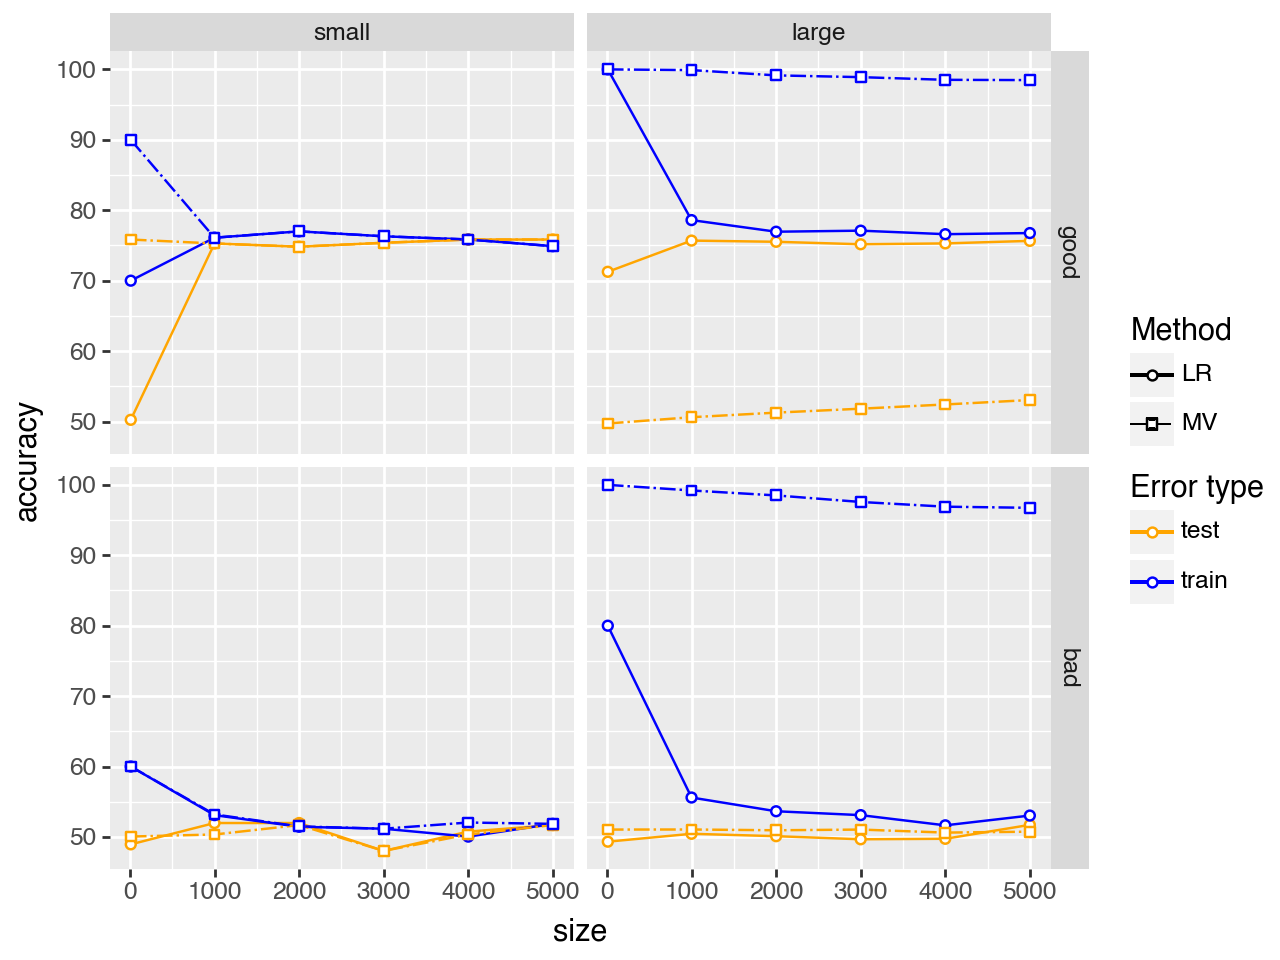

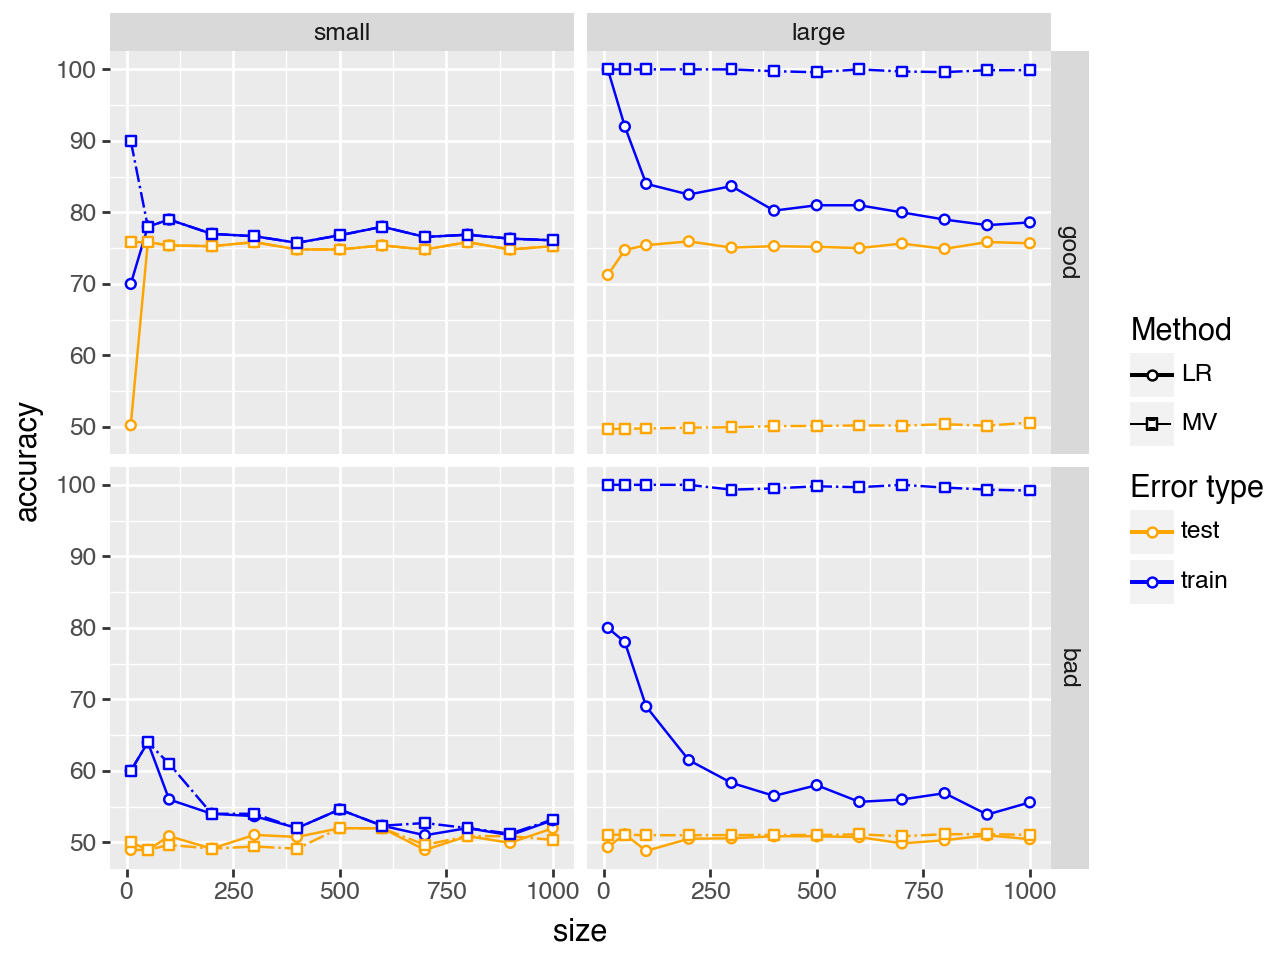

In [56]:
# Large-scale plot
p = ggplot(data = df.loc[error['size'].isin([10, 1000, 2000, 3000, 4000, 5000]),:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(rows='fit', cols='dim')
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'])
# p.save('convergence-large.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Small-scale plot
p = ggplot(data = df.loc[error['size'] <= 1000,:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(rows='fit', cols='dim')
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'])
# p.save('convergence-small.pdf', path='results', height=6, width=12, verbose=False)
display(p)

**Interpretation:** 
* When the number of input features is small and thus the learning task is easy, all method converge quickly to true risk -- test and training accuracy reaches 75% for the learnable task (good) and 50% for unlearnable task (bad). Also, the spread between training and test accuracy (optimism aka generalisation gap) is small.
  
*  When the number of input features is large and thus the learning task is hard:
   * Logistic regression as less flexible method converges quickly to true risk and the spread between test and training accuracy remains small.
   * Majority voting as the most flexible method shows much slower convergence -- the decent of training accuracy is barely noticable. This is expected as most inputs in the training set are unique and thus the classifier can memorise the correct answer.  